## Final Project Submission

Please fill out:
* Student name: Group 2
* Student pace: full time remote
* Scheduled project review date/time: 10/02/2026
* Instructor name: Samuel.G.Mwangi
* Blog post URL:brian-chairo.hashnode.dev


# Movie Studio Market Analysis
## Stakeholder
Head of the New Movie Studio

### Problem Statement
Our company is launching a new movie studio and needs to decide what types of films to produce in order to maximize box office success. However, the company currently lacks historical knowledge about which movie characteristics lead to strong financial performance.

### Business Understanding
#### KEY QUESTIONS FOR MOVIE STUDIO STRATEGY
1. Which movie genres generate the highest revenue? By analyzing the total earnings from the different genres, we can determine which types of films are more profitable and likely to attract large audiences.
2. Does movie rating or critic score correlate with higher box office success? using ratings from Rotten Tomatoes and movie database, we can measure whether higher-rated movies earn more revenue 
3. Does a longer runtime affect rating or revenue? By analyzing the runtimes in the dataset, we can identify which runtimes generate higher earnings for different types of movies.
4. Does the release timing affect the earnings? By examining which years and their associated revenue, we can identify the optimal times to launch films for maximum success.

In [2]:
# Unzipping the database in code
import zipfile
import os

zip_path = r"C:\Users\Administrator\Documents\Flatiron\Phase_2\Wk3\Movie-Studio-EDA-Project\zippedData\im.db.zip"
extract_to = r"C:\Users\Administrator\Documents\Flatiron\Phase_2\Wk3\Movie-Studio-EDA-Project\data"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Database extracted!")


Database extracted!


 The cell code below imports the necessary Python libraries for use, create a variable for the database path and connects to the database.
We finalise by checking the tables that exist in the sqlite database.

In [3]:
#import libraries
import sqlite3
import pandas as pd

# Path to the database
db_path = r"C:\Users\Administrator\Documents\Flatiron\Phase_2\Wk3\Movie-Studio-EDA-Project\data\im.db"

# Connect to the database
conn = sqlite3.connect(db_path)

#check tables in the database
tables = pd.read_sql("""
SELECT name 
FROM sqlite_master 
WHERE type='table';
""", conn)

tables


,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


## Filtering movie_basics table to only remain with what we need 
We focus on movies produced after the year 2000!
This step is important as older movies are less relevant, missing runtimes are useless, smaller dataset is faster

In [4]:
# Query Movie_basics table|Filtering only what we need
query_basics = """
SELECT
    movie_id,
    primary_title,
    start_year,
    runtime_minutes,
    genres
FROM movie_basics
WHERE start_year >= 2000
AND runtime_minutes IS NOT NULL
"""
# Load the data
basics = pd.read_sql(query_basics, conn)
basics.head()

,movie_id,primary_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama
3,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy"
4,tt0111414,A Thin Life,2018,75.0,Comedy


## Data quality Filtering movie_ratings table 
Where votes equalls to 3 or less is not reliable rating thus by filtering we remove the noise.
Ratings with 3 or fewer votes are considered noise because they are statistically unreliable.

**Movies with few votes tend to have unreliable ratings. Filtering them out removes noise and ensure the analysis reflects broader audience opinions.**

In [5]:
# Query the movie_ratings table to filter out noise
query_ratings = """
SELECT
    movie_id,
    averagerating,
    numvotes
FROM movie_ratings
WHERE numvotes >= 50
"""
# load ratings
ratings = pd.read_sql(query_ratings, conn)
ratings.head()

,movie_id,averagerating,numvotes
0,tt10384606,8.9,559
1,tt1043726,4.2,50352
2,tt1069246,6.2,326
3,tt1094666,7.0,1613
4,tt1130982,6.4,571


## Merging Datasets
* IMDB - Sqlite database, Ratings and Basics table
* BOM - CSV
* TMDB - CSV
#### Merging the basics and ratings table 

In [6]:
#Merge IMDB tables
imdb = basics.merge(ratings, on="movie_id", how="left")
imdb.head()

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",NaN,NaN
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0
3,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0
4,tt0111414,A Thin Life,2018,75.0,Comedy,NaN,NaN


#### Load the bom csv file

In [7]:
# load Box Office CSV
box = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
box.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


#### Inspect bom dataset using the .info() function, to see the datatypes and missing values in each column. 

In [8]:
box.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


#### Convert foreign_gross from object to numeric. 
This helps us aggregate the total gross revenue.

In [9]:
box['foreign_gross'] = pd.to_numeric(
    box['foreign_gross'], errors='coerce'
)
box.dtypes


title              object
studio             object
domestic_gross    float64
foreign_gross     float64
year                int64
dtype: object

In [10]:
box['total_gross'] = box['domestic_gross'] + box['foreign_gross']
box['title'] = box['title'].str.strip()

#### Load tmdb.csv dataset

In [11]:
tmdb = pd.read_csv("zippedData/tmdb.movies.csv.gz")
tmdb.head(100)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
95,95,"[35, 27]",43593,en,Piranha 3D,11.302,2010-08-20,Piranha 3D,5.3,1029
96,96,"[12, 18, 28, 14]",37861,en,Valhalla Rising,11.260,2010-07-16,Valhalla Rising,6.0,582
97,97,"[80, 18, 9648, 53]",12201,en,Edge of Darkness,11.252,2010-01-29,Edge of Darkness,6.3,794
98,98,"[14, 12, 28, 9648]",35552,fr,Les Aventures extraordinaires d'Adèle Blanc-Sec,11.221,2010-04-14,The Extraordinary Adventures of Adèle Blanc-Sec,6.0,671


### Final merge imdb + bom + tmdb

In [12]:
#Final Merge
working_df = (
    imdb
    .merge(box, left_on="primary_title", right_on="title", how="left")
    .merge(tmdb, left_on="primary_title", right_on="title", how="left", suffixes=('_imdb','_tmdb'))
)
working_df.head()

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_imdb,studio,domestic_gross,...,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title_tmdb,vote_average,vote_count
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0,NaN,NaN,NaN,...,24185.0,"[35, 18]",299782.0,en,The Other Side of the Wind,9.8,2018-11-02,The Other Side of the Wind,7.0,64.0
3,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0111414,A Thin Life,2018,75.0,Comedy,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Although Rotten Tomatoes data was initially considered, it lacked a reliable
join key with other datasets. TMDB was used instead because it provides movie
titles and structured metadata, enabling accurate merging and richer analysis.

## Saving the working_df
* For reproducibility to avoid rerunning merges everytime
* Faster reading of the csv


In [13]:
os.makedirs("data/processed", exist_ok=True)

working_df.to_csv("data/processed/movies_clean.csv", index=False)

# Exploratory Data Analysis (EDA)

This notebook explores the cleaned movie dataset to identify
patterns that explain box office success.

Goal:
Generate insights to recommend what types of movies the new studio should produce.


## Key Questions

1. Which genres earn the highest revenue?
2. Do higher ratings lead to higher revenue?
3. What runtime performs best?


#### Load the movies_clean merged dataset

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/processed/movies_clean.csv")

df.head()


,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_imdb,studio,domestic_gross,...,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title_tmdb,vote_average,vote_count
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0,NaN,NaN,NaN,...,24185.0,"[35, 18]",299782.0,en,The Other Side of the Wind,9.8,2018-11-02,The Other Side of the Wind,7.0,64.0
3,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0111414,A Thin Life,2018,75.0,Comedy,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Inspect column names of the merged dataset
df.columns.tolist()

['movie_id',
 'primary_title',
 'start_year',
 'runtime_minutes',
 'genres',
 'averagerating',
 'numvotes',
 'title_imdb',
 'studio',
 'domestic_gross',
 'foreign_gross',
 'year',
 'total_gross',
 'Unnamed: 0',
 'genre_ids',
 'id',
 'original_language',
 'original_title',
 'popularity',
 'release_date',
 'title_tmdb',
 'vote_average',
 'vote_count']

In [16]:
# standardise the column names 
df = df.rename(columns={
    "primary_title": "title",
    "runtime_minutes": "runtime",
    "averagerating": "rating",
    "numvotes": "votes",
    "total_gross": "gross"
})


In [17]:
# Drop junk columns
df = df.drop(columns=[
    "Unnamed: 0",
    "title_imdb",
    "title_tmdb",
    "id",
    "genre_ids"
], errors="ignore")


## What type of movie should we produce?

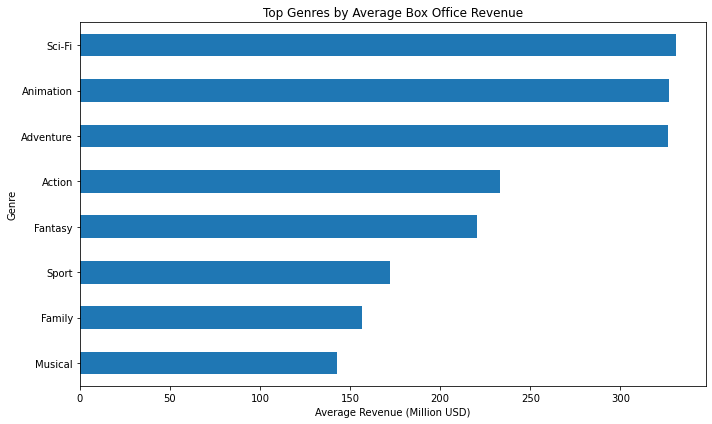

In [18]:
# Clean genre analysis 

# split multi-genres into list
df["genres"] = df["genres"].str.split(",")

# explode so each genre gets its own row
df_genre = df.explode("genres")

# compute average revenue
genre_revenue = (
    df_genre
    .groupby("genres")["gross"]
    .mean()
    .sort_values(ascending=False)
    .head(8)   # fewer = clearer for stakeholders
)

# convert to millions for readability
genre_revenue = genre_revenue / 1_000_000

# plot (horizontal = easier to read)
plt.figure(figsize=(10,6))

genre_revenue.sort_values().plot(kind="barh")

plt.xlabel("Average Revenue (Million USD)")
plt.ylabel("Genre")
plt.title("Top Genres by Average Box Office Revenue")

plt.tight_layout()
plt.savefig('data/images/Top Genres by Average Box Office Revenue', dpi=300, bbox_inches='tight')
plt.show()


Sci-Fi, Animation, and Adventure films generate the highest average
box office revenue. The studio should prioritize producing films in
these genres to maximize financial performance.


# Does quality matter?
Should the studio focus on quality or just volume
* do higher ratings = higher revenue?
* Is there a trend?

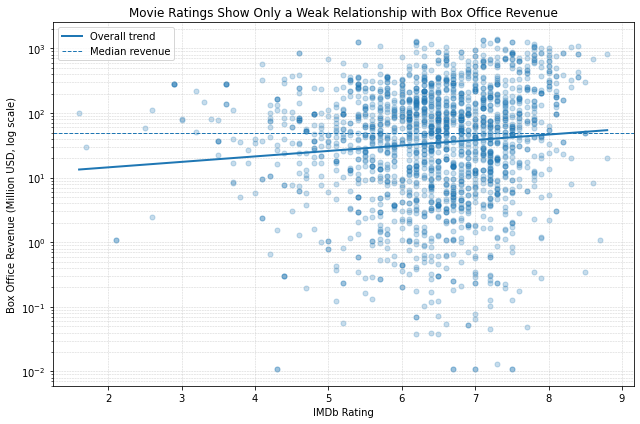

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare & clean data 
df_plot = df[["rating", "gross"]].dropna()
df_plot = df_plot[df_plot["gross"] > 0]  # log scale safety

x = df_plot["rating"]
y = df_plot["gross"] / 1_000_000  # Revenue in million USD

plt.figure(figsize=(9, 6))

# --- Scatter plot ---
plt.scatter(
    x,
    y,
    alpha=0.25,     # reduce overplotting
    s=25
)

# --- Log scale for skewed revenue ---
plt.yscale("log")

# --- Trend line (visual guidance, not prediction) ---
# Sort x for a clean trend line
order = np.argsort(x)
x_sorted = x.iloc[order]
y_sorted = y.iloc[order]

z = np.polyfit(x_sorted, np.log(y_sorted), 1)
p = np.poly1d(z)

plt.plot(
    x_sorted,
    np.exp(p(x_sorted)),
    linewidth=2,
    label="Overall trend"
)

# --- Reference line: median revenue ---
median_rev = y.median()
plt.axhline(
    median_rev,
    linestyle="--",
    linewidth=1,
    label="Median revenue"
)

# --- Labels & title (stakeholder-friendly) ---
plt.xlabel("IMDb Rating")
plt.ylabel("Box Office Revenue (Million USD, log scale)")
plt.title("Movie Ratings Show Only a Weak Relationship with Box Office Revenue")

# --- Grid improves readability ---
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

# --- Legend ---
plt.legend()

plt.tight_layout()
plt.savefig('data/images/Movie Ratings Show Only a Weak Relationship with Box Office Revenue', dpi=300, bbox_inches='tight')
plt.show()


## Scatter Plot explanation
The dots represents one movie. The y-axis is on a log scale, vertical distance reflects orders of magnitude in revenue
* $10M 
* $100M
* $1Bill

Most movies earn relatively low revenue, from low to high ratings. We therefore conclude that high ratings do not guarantee commercial success.

#### **Overall Trend**
Movie with higher ratings tend to earn somewhat more, but the effect is weak. **The slope(solid blue line)** is gentle, it only explain only a small part of revenue differences.

**The Median Revenue(The dashed horizontal line)**
This is the typical movie's revenue, Notice how most movies, even at higher ratings, lie below the line.
Even highly rated movies often earn below median revenue!

## When should we release our movies to make the most money?
* release_date from TMDB
* revenue(gross) from BOM

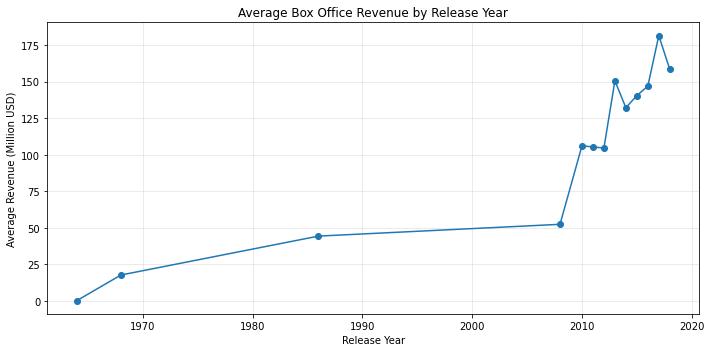

In [27]:
# Convert release_date to datetime
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")

# Keep only valid rows
df_time = df.dropna(subset=["release_date", "gross"]).copy()

# Extract release year
df_time["release_year"] = df_time["release_date"].dt.year

# Compute average revenue per year
year_revenue = (
    df_time
    .groupby("release_year")["gross"]
    .mean()
    / 1_000_000   # convert to millions
)

# Plot
plt.figure(figsize=(10,5))
plt.plot(year_revenue.index, year_revenue.values, marker="o")

plt.xlabel("Release Year")
plt.ylabel("Average Revenue (Million USD)")
plt.title("Average Box Office Revenue by Release Year")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data/images/Average Box Office Revenue by Release Year', dpi=300, bbox_inches='tight')
plt.show()


## Average box office revenue per movie for each release year
* Each point represents the mean revenue of all movies released in a particular year, measured in millions per year
* It shows long term trends and allows us to see the evolution of movies over time

- The upward trend show us that the movies average earning increases over time
- The drops suggests possible market saturation, economic shift and data gaps
- Smoother Line show the aggregated insights




### Does movie duration affect ratings or revenue?
Here we check runtime against rating and revenue in the merged df. Scatter plots for patterns and Correlation to investigate and quantify the relationship.

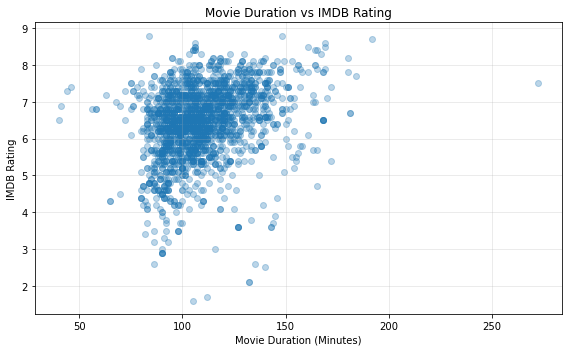

In [28]:
# Keep only relevant columns and valid values
df_runtime = df.dropna(subset=["runtime", "rating", "gross"]).copy()

# Convert revenue to millions for readability
df_runtime["gross"] = df_runtime["gross"] / 1_000_000

# Does runtime affect rating?
plt.figure(figsize=(8,5))

plt.scatter(
    df_runtime["runtime"],
    df_runtime["rating"],
    alpha=0.3
)

plt.xlabel("Movie Duration (Minutes)")
plt.ylabel("IMDB Rating")
plt.title("Movie Duration vs IMDB Rating")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data/images/Movie Duration vs IMDB Rating', dpi=300, bbox_inches='tight')
plt.show()


In [22]:
# Coorreltion between IMDB rating & Movie Duration
rating_corr = df_runtime["runtime"].corr(df_runtime["rating"])
rating_corr

0.2963551885678206

**Longer movies tend to receive slightly higher ratings, but the effect is small and inconsistent**

There is a weak positive correlation (r ≈ 0.30) between movie duration and IMDB rating. This suggests that longer films tend to receive slightly higher ratings on average, but duration alone explains very little of the variation in ratings. Other factors such as storytelling quality, genre, and production value are far more influential.

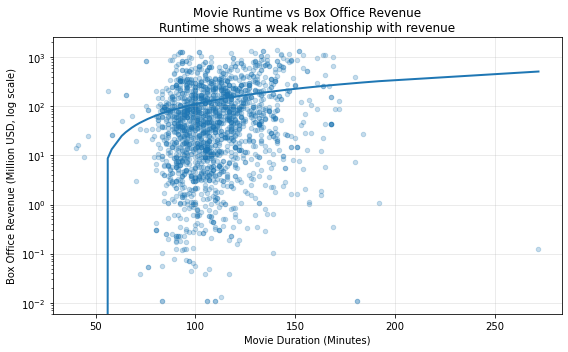

In [29]:
## Duration vs revenue (Does runtime affect revenue?)
import numpy as np
import matplotlib.pyplot as plt

# Clean data for plotting
plot_df = df_runtime[
    (df_runtime["gross"] > 0) &
    (df_runtime["runtime"].notna())
].sort_values("runtime")

# Create figure
plt.figure(figsize=(8, 5))

# Scatter plot
plt.scatter(
    plot_df["runtime"],
    plot_df["gross"],
    alpha=0.25,
    s=20
)

# Trend line
z = np.polyfit(plot_df["runtime"], plot_df["gross"], 1)
p = np.poly1d(z)
plt.plot(
    plot_df["runtime"],
    p(plot_df["runtime"]),
    linewidth=2
)

# Log scale for revenue
plt.yscale("log")

# Labels and title
plt.xlabel("Movie Duration (Minutes)")
plt.ylabel("Box Office Revenue (Million USD, log scale)")
plt.title(
    "Movie Runtime vs Box Office Revenue\n"
    "Runtime shows a weak relationship with revenue"
)

# Styling
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data/images/Movie Runtime vs Box Office Revenue', dpi=300, bbox_inches='tight')
plt.show()




In [24]:
# Correlation. we check the relation between revenue and runtime
revenue_corr = df_runtime["runtime"].corr(df_runtime["gross"])
revenue_corr


0.20371407845212083

There is a weak positive relationship between movie runtime and box office revenue (correlation = 0.20).
While longer movies tend to earn slightly more on average, runtime alone explains very little of the variation in revenue. Other factors such as genre, franchise status, marketing, and release timing are far more influential.

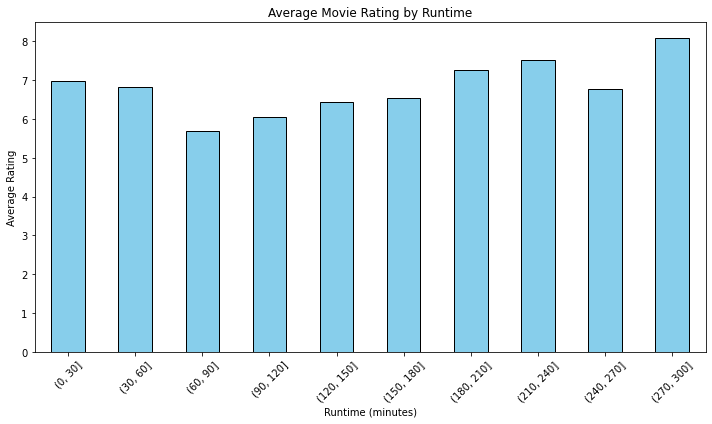

In [32]:
# Define bins for runtime (e.g., every 30 minutes)
bins = np.arange(0, 301, 30)  # 0-30, 30-60, ..., 270-300
df['runtime_bin'] = pd.cut(df['runtime'], bins)

# Calculate average rating per runtime bin
avg_rating_per_bin = df.groupby('runtime_bin')['rating'].mean()

# Plot bar graph
plt.figure(figsize=(10,6))
avg_rating_per_bin.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Movie Rating by Runtime")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('data/images/Average Movie Rating by Runtime', dpi=300, bbox_inches='tight')
plt.show()

The bar graph shows a weak relationship between runtime and rating suggesting that runtime alone is not a strong predictor of movie ratings. The studio should focus on quality.

## Recommendation 1
Investing in Sci-Fi, Animation and Adventure offers the strongest opprtunity to maximize box office performance while supporting long term growth.

## Recommendation 2
Strong ratings improve average performance slightly, but they are not a reliable predictor of box office success and should not be used in isolation for investment decisions.

## Recommendation 3
Despite short-term volatility, the long-term upward trend in average box office revenue supports sustained investment, with flexibility to adapt during market downturns.

Plan future investments with a long-term growth mindset while remaining agile to short-term market fluctuations.
Average box office revenue per movie has increased over time, indicating sustained growth potential in the industry, but periodic declines highlight the need for flexibility.


## Recommendation 4
While longer films receive slightly higher ratings on average, the impact is small and inconsistent, and runtime alone does not meaningfully influence how audiences rate a movie. Avoid using movie length as a primary lever to improve audience ratings

## Recommendation 5 
While longer films tend to receive slightly higher ratings on average, the effect is **small and inconsistent**. Movie runtime alone does **not meaningfully influence** how audiences rate a movie. Focus on other factors such as story quality, cast performance, and production values to improve ratings.Avoid using movie length as a primary lever to improve audience ratings